## Practice 1: Measuring T1

In [1]:
'''Import libraries'''
from qmio import QmioRuntimeService
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

service = QmioRuntimeService() 

In [2]:
'''
Function to run instructions on QPU.
If the job yields an error, the message is printed.
'''

def run_instruction(_backend, _instruction, _shots):
    _res = _backend.run(circuit = _instruction, shots = _shots, res_format = 'raw')
    try :
        return _res["results"].reshape((_shots,))
    except :
        print(_res)

In [3]:
'''
Here you will define the instructions to measure T1:

    - First, apply an X gate on the target qubit, for example: x $21; 
    
    - Now add a delay with the input time of the function. Remember to use
      the {} delimiters to introduce this value on the instruction string: delay[{_time}ns] $21;
      
    - Finally, add the measure instruction: measure $21;
'''

def set_instructions(_time):
    _instructions = f'''
    OPENQASM 3;
    
        // Add your code here
    x $21;
    delay[{_time}ns] $21; 
    measure $21; 
    '''
    return _instructions

In [4]:
'''
Run the experiment on the QPU
'''

max_time = 4e5 # ns
num_steps = 10 # number of delays
delays = np.linspace(0.0, max_time, num_steps)        
shots = 1000                              

results = []
with service.backend(name = "qpu") as backend:  # Open a session with the QPU                                
    for t in delays: # Sweep the values for the delays
        inst = set_instructions(t)  # Build the instruction for the specific time                                           
        res = run_instruction(backend,  inst, shots) # Run the job on the QPU
        results.append(res) # Save the results                                               

Waiting for resources


In [5]:
'''
Classify the outputs:

    - Value > 0, then classify to |0>
    
    - Value < 0, then classify to |1>
    
For this experiment, we want to compute the probability of P1 after each delay. 
The following function computes this value for each time delay.
'''

p1 = np.zeros(len(results)) 

for i in range(len(results)):
    for n in range(shots):
        if results[i][n] < 0:
            p1[i] += 1
            
p1 = p1 / shots

coeffs: [4.86026772e-01 2.92561920e-05 1.52996314e-01]


Text(0, 0.5, '$P_1$')

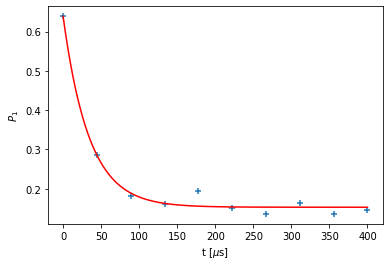

In [6]:
'''
    The scipy function curve_fit is used to fit the data to the exponential expression
    derived from the qubit thermalization behaviour studied before.
'''
from scipy.optimize import curve_fit

def func(x, a, c, d): 
    return a*np.exp(-c*x)+d

popt, pcov = curve_fit(func, delays, p1, p0 = (1, 20e-6, 0))

tt = np.linspace(0, max(delays), 1000)
yy = func(tt, *popt)

print(f'coeffs: {popt}')
plt.scatter(delays/1e3, p1, marker = '+')
plt.plot(tt/1e3, yy,color = 'red')
plt.xlabel(r't [$\mu$s]')
plt.ylabel(r'$P_1$')

In [7]:
print(f'T1: {1/popt[1]*1e-9:0.4e}s')

T1: 3.4181e-05s
